# Sfaira pbmc3k automatic analysis

Manual preprocessing and annotation of single cell data is a repetitive and cumbersome process. Sfaira offers an alternative by automatically embedding and annotating cell types using pretrained machine learning models (e.g. autoencoders).

The following tutorial will be comparing a manual annotation of the pbmc3k human PBMC dataset published by 10x Genomics with an automatic annotation conducted with Sfaira. By doing so we will recreate the corresponding figure of the manuscript. This notebook is inspired by and contains content from the Scanpy tutorial: https://github.com/theislab/scanpy-tutorials/blob/master/pbmc3k.ipynb.

We will start off by loading the dataset if required.

# Load data

In [1]:
# !mkdir data
# !mkdir panels
# !wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
# !cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import sys
import warnings

model_dir_sfaira = "."

sc.settings.verbosity = 3
sc.settings.figdir = "panels/"
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(6, 6), facecolor='white')

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [3]:
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True
)

... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad


In [4]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
sc.pp.filter_cells(adata, min_genes=200)

In [5]:
adata_sfaira = adata.copy()

In [6]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    obs: 'n_genes'
    var: 'gene_ids'

# Manual feature processing with scanpy

The goal of the following preprocessing is to remove low quality data and to reduce unwanted data distribution effects to try to focus on biological variance only.

The manual feature processing will first conduct basic quality control by filtering out genes with few cells and cells with many mitochondrial reads. Afterwards, the data will be log-normalized, scaled, regressed and subsetted to highly variable genes only.

Based on visual exploration of the UMAP embedded data and marker genes the with Leiden clustering obtained cell clusters will be manually renamed to generate an embedded and annotated dataset.

## Preprocessing

normalizing counts per cell
    finished (0:00:00)


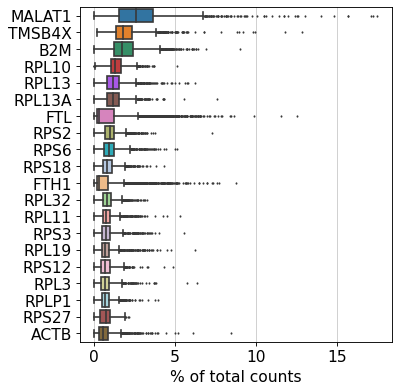

In [7]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [8]:
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


In [9]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, inplace=True)

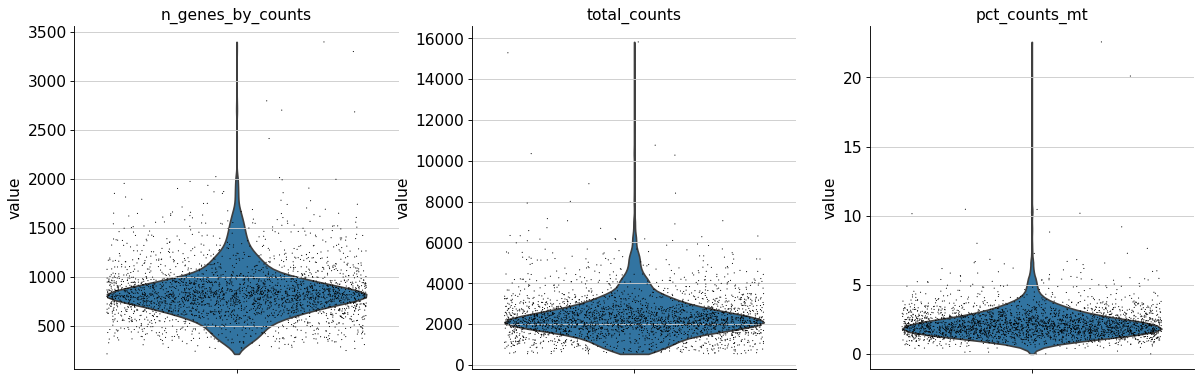

In [10]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

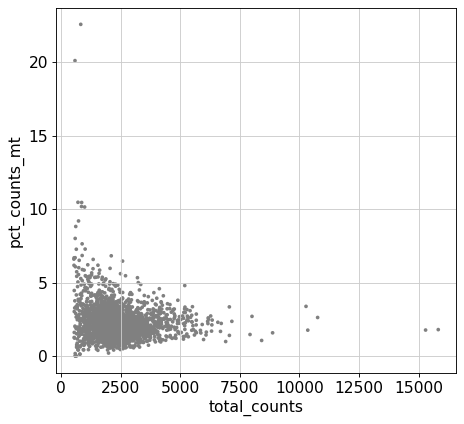

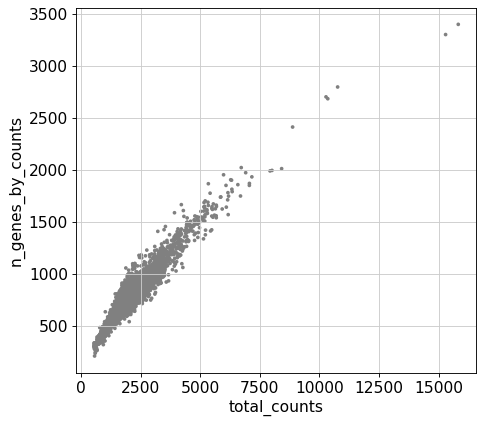

In [11]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [12]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [13]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


In [14]:
sc.pp.log1p(adata)

In [15]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


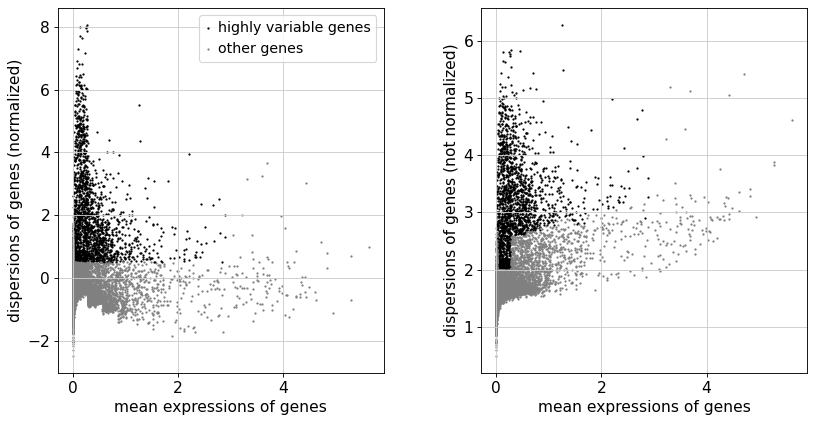

In [16]:
sc.pl.highly_variable_genes(adata)

In [17]:
adata.raw = adata

In [18]:
adata = adata[:, adata.var.highly_variable]

In [19]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:05)


In [20]:
sc.pp.scale(adata, max_value=10)

## Principal component analysis

In [21]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


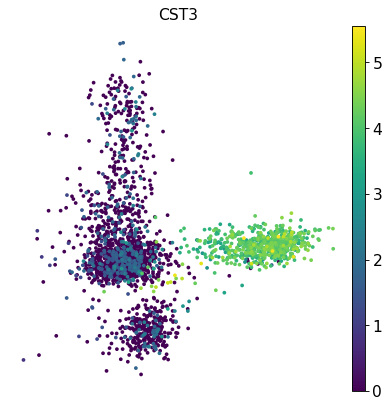

In [22]:
sc.pl.pca(adata, color='CST3')

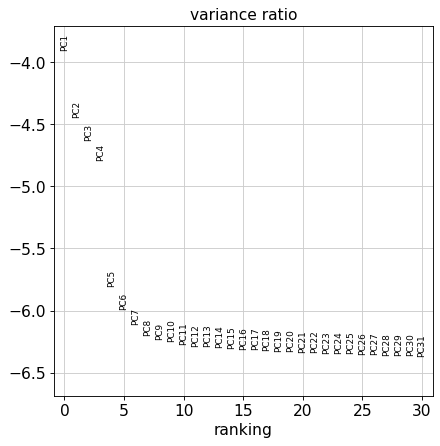

In [23]:
sc.pl.pca_variance_ratio(adata, log=True)

## Computing the neighborhood graph

In [24]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:15)


## Embedding the neighborhood graph

In [25]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


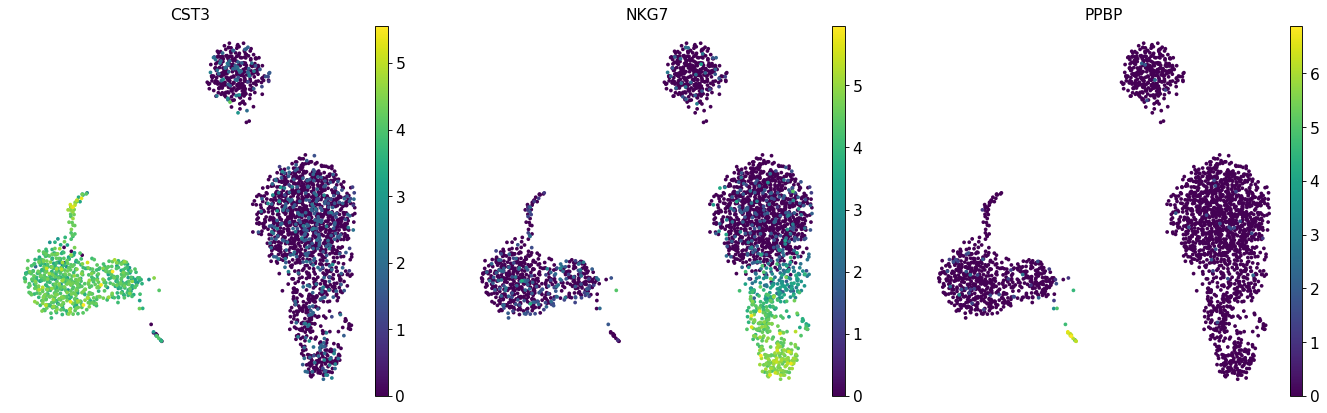

In [26]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

## Clustering the neighborhood graph

In [27]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


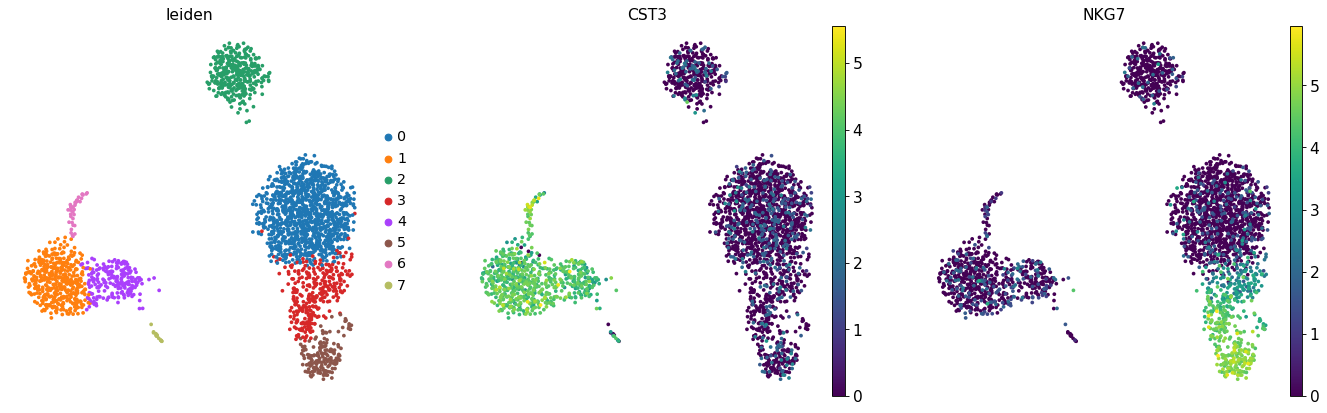

In [28]:
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

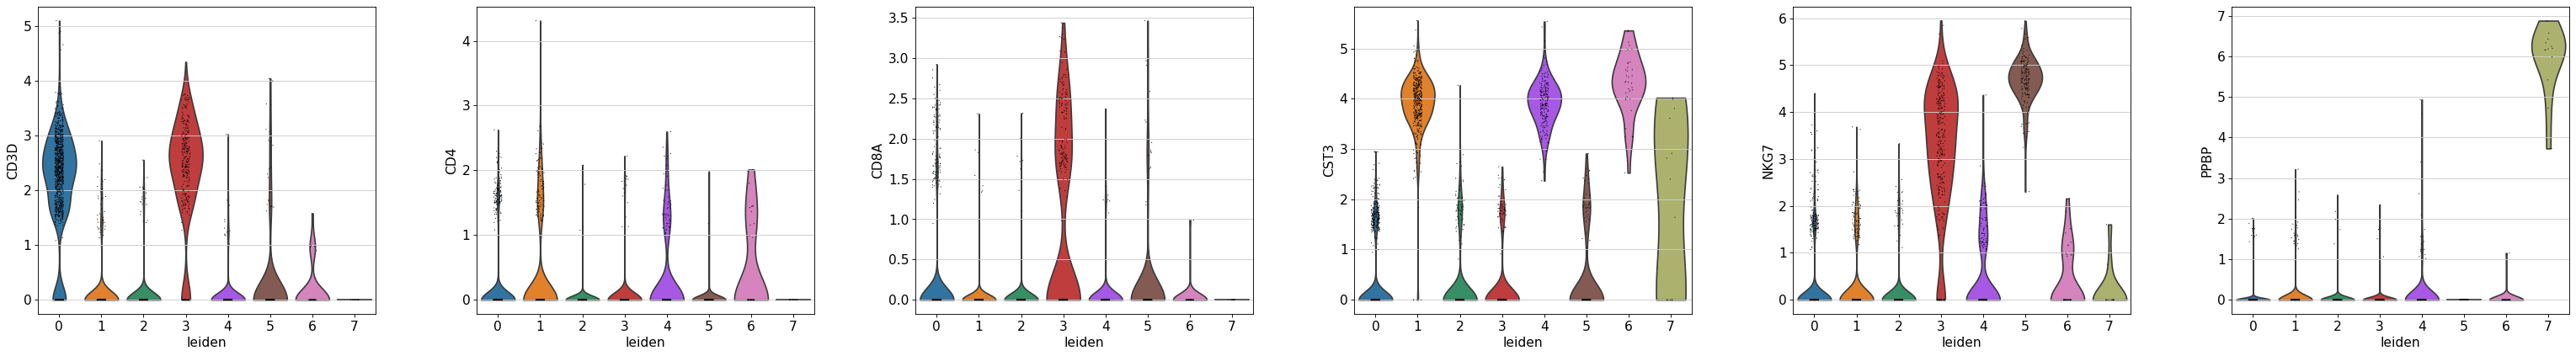

In [29]:
sc.pl.violin(adata, ['CD3D', 'CD4', 'CD8A', 'CST3', 'NKG7', 'PPBP'], groupby='leiden')

## Finding marker genes

In [30]:
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T', 
    'FCGR3A Monocytes', 'NK',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)
adata.obs["leiden"].value_counts()

CD4 T               1140
CD14 Monocytes       431
B                    341
CD8 T                311
FCGR3A Monocytes     205
NK                   161
Dendritic             36
Megakaryocytes        13
Name: leiden, dtype: int64

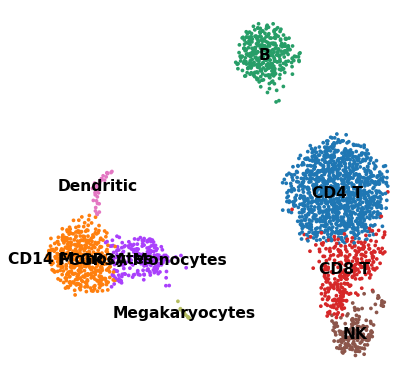

In [31]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False)

# Automated analysis with sfaira

Sfaira provides automatic analysis capabilities in the form of lower dimensional embeddings and cell annotations.

We will embed our data using the 'embedding_human_blood_linear_theislab_0.1_0.1' model. It is a linear model which was primarily designed for human blood, is provided by the Theislab and runs with hyperparameter version 0.1 and parameter version 0.1. 
Then we will simply pass the best pretrained weights to the model to create the embedding.

In [32]:
import sfaira

Ontology <class 'sfaira.versions.metadata.base.OntologyMondo'> is not a DAG, treat child-parent reasoning with care.
Ontology <class 'sfaira.versions.metadata.base.OntologyUberon'> is not a DAG, treat child-parent reasoning with care.


In [33]:
model_id_embedding = "embedding_human-blood-ae-0.2-0.1_theislab"
model_id_type = "celltype_human-blood-mlp-0.1.3-0.1_theislab"

In [34]:
ui = sfaira.ui.UserInterface(
    custom_repo=os.path.join(model_dir_sfaira),
    sfaira_repo=False
)
ui.zoo_embedding.model_id = model_id_embedding
ui.zoo_celltype.model_id = model_id_type
ui.load_data(data=adata_sfaira, gene_symbol_col="index", gene_ens_col="gene_ids")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [35]:
ui.load_model_embedding()
ui.predict_embedding()
adata_sfaira = ui.data.adata

sc.pp.neighbors(adata_sfaira, use_rep="X_sfaira")
sc.tl.umap(adata_sfaira)

passed hyperpar: 
 {'latent_dim': (256, 128, 64, 128, 256), 'l1_coef': 1e-06, 'l2_coef': 1e-06, 'dropout_rate': 0.2, 'input_dropout': 0.0, 'batchnorm': True, 'activation': 'selu', 'init': 'lecun_normal', 'output_layer': 'nb_shared_disp'}
found 2700 observations


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


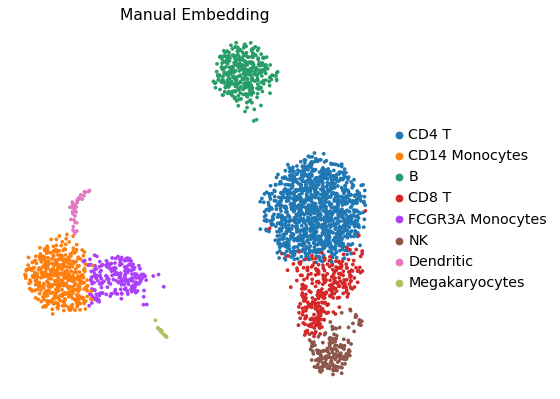

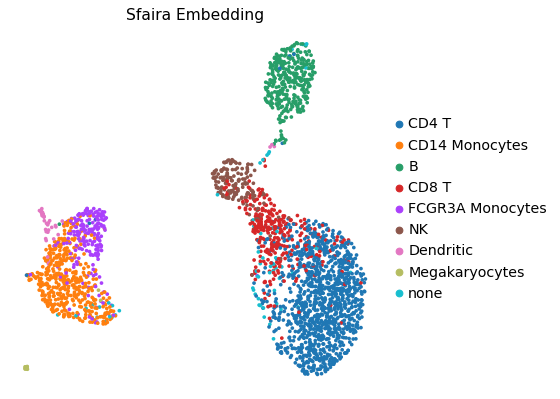

In [36]:
# Plot the results

adata_sfaira.obs["clusters_scanpy"] = pd.Categorical([
    adata.obs.loc[x, "leiden"] if x in adata.obs_names else "none"
    for x in adata_sfaira.obs_names
], categories=list(adata.obs["leiden"].values.categories)+["none"])

sc.pl.umap(adata, color="leiden", show=True, title="Manual Embedding")
sc.pl.umap(adata_sfaira, color="clusters_scanpy", show=True, title="Sfaira Embedding")

In [37]:
ui.load_model_celltype()
ui.predict_celltypes()
adata_sfaira = ui.data.adata

passed hyperpar: 
 {'units': [512, 256, 128], 'activation': 'selu', 'use_bias': True, 'l1_coef': 1e-06, 'l2_coef': 1e-06, 'kernel_initializer': 'lecun_normal', 'bias_initializer': 'zeros', 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None, 'dropout_rate': 0.2}
found 2700 observations


In [38]:
# Shorten Cell Ontology names for legend:
name_map = {
    'hematopoietic stem cell': "HSC",
    'erythrocyte': "erythrocyte",
    'platelet': "platelet",
    'macrophage': "macrophage",
    'megakaryocyte': "megakaryocyte",
    'erythroblast': "erythroblast",
    'eosinophil': "eosinophil",
    'neutrophil': "neutrophil",
    'myeloid dendritic cell': "myeloid DC",
    'plasma cell': "plasma cell",
    'memory B cell': "memory B cell",
    'naive B cell': "naive B cell",
    'gamma-delta T cell': 'gd T cell',
    'hematopoietic multipotent progenitor cell': "HMPC",
    'naive thymus-derived CD4-positive, alpha-beta T cell': "naive CD4 T cell",
    'naive thymus-derived CD8-positive, alpha-beta T cell': "naive CD8 T cell",
    'central memory CD4-positive, alpha-beta T cell': "central memory CD4 T cell",
    'effector memory CD4-positive, alpha-beta T cell': "effector memory CD4 T cell",
    'central memory CD8-positive, alpha-beta T cell': "central memory CD8 T cell",
    'effector memory CD8-positive, alpha-beta T cell': "effector memory CD8 T cell",
    'CD4-positive, alpha-beta cytotoxic T cell': "cytotoxic CD4 T cell",
    'CD16-negative, CD56-bright natural killer cell, human': "NK",
    'mucosal invariant T cell': "MAIT",
    'plasmablast': "plasmablast",
    'plasmacytoid dendritic cell, human': "plasmacytoid DC",
    'CD14-low, CD16-positive monocyte': "monocyte",
    'double negative thymocyte': "DN T cell",
    'naive regulatory T cell': "naive Treg",
    'memory regulatory T cell': "memory Treg"
}

adata_sfaira.obs["clusters_scanpy"] = pd.Categorical([
    adata.obs.loc[x, "leiden"] if x in adata.obs_names else "none"
    for x in adata_sfaira.obs_names
])
adata.obs["clusters_scanpy"] = pd.Categorical([
    x for x in adata.obs["leiden"].values
])

adata_sfaira.obs["celltypes_sfaira_short"] = [
    name_map[x]
    for x in adata_sfaira.obs["celltypes_sfaira"].values
]
adata_sfaira.obs["celltypes_sfaira_short"] = pd.Categorical(adata_sfaira.obs["celltypes_sfaira_short"])
    
adata.obs["celltypes_sfaira_short"] = pd.Categorical([
    adata_sfaira.obs.loc[x, "celltypes_sfaira_short"]
    for x in adata.obs_names
], categories=list(adata_sfaira.obs["celltypes_sfaira_short"].values.categories))

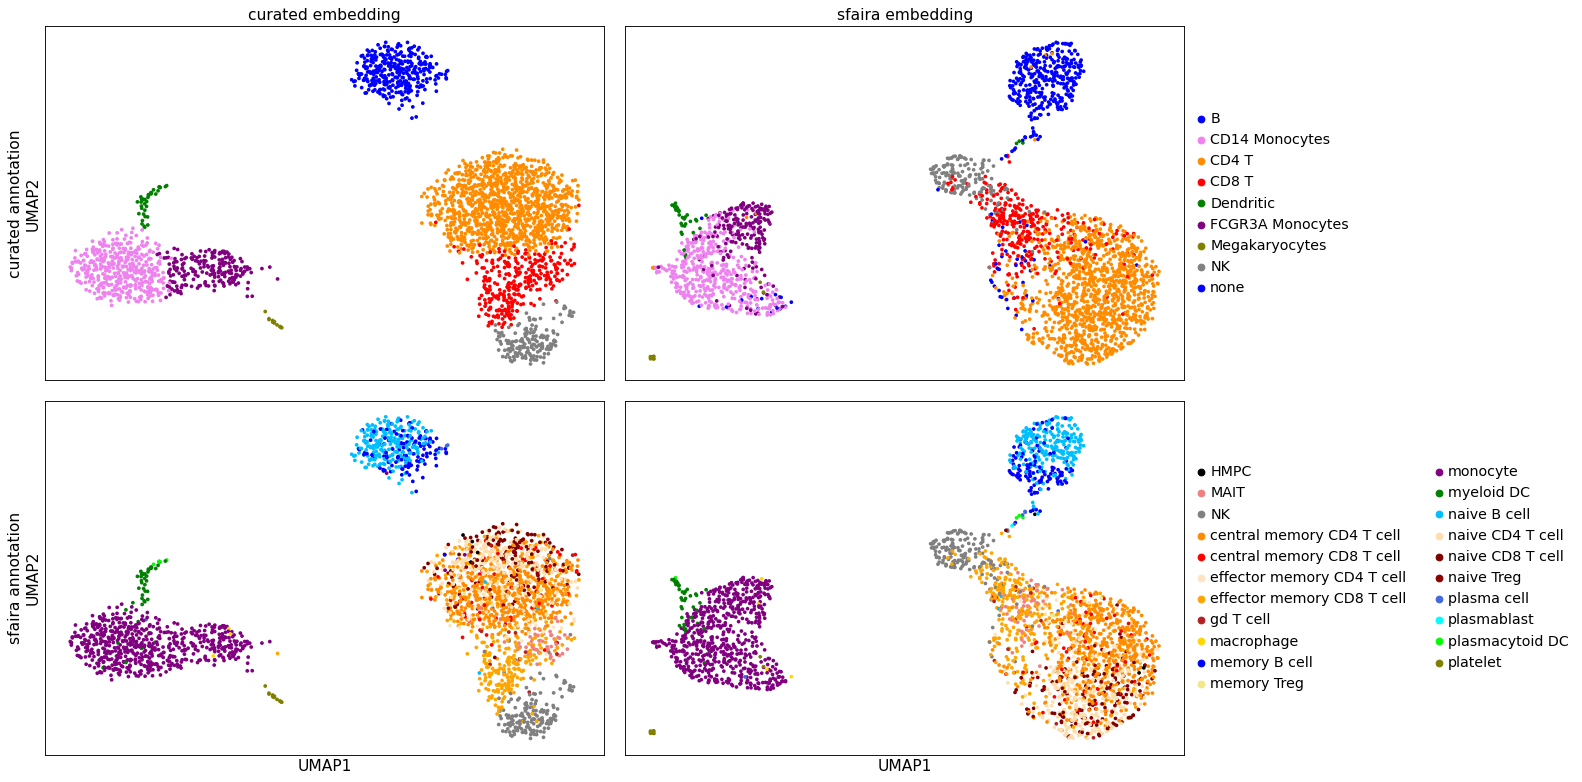

In [39]:
import matplotlib
import matplotlib.pyplot as plt
sc.settings.set_figure_params(dpi=80, frameon=True, figsize=(6, 6), facecolor='white')

fig, axs = plt.subplots(2,2, figsize=(20,10))
sc.pl.umap(adata, color="clusters_scanpy", show=False, title="curated embedding", ax=axs[0,0], 
           palette=["blue", "violet", "darkorange", "red", "green", "purple", "olive", "grey"])
axs[0,0].legend_.remove()
axs[0,0].set_xlabel("")
axs[0,0].set_ylabel("curated annotation\nUMAP2")
sc.pl.umap(adata_sfaira, color="clusters_scanpy", show=False, title="sfaira embedding", ax=axs[0,1], 
           palette=["blue", "violet", "darkorange", "red", "green", "purple", "olive", "grey"])
axs[0,1].set_xlabel("")
axs[0,1].set_ylabel("")
sc.pl.umap(adata, color="celltypes_sfaira_short", show=False, title="", ax=axs[1,0],
           palette=["black", "lightcoral", "grey", "darkorange", "red", "bisque", "orange", "firebrick", "gold", "blue", "khaki", "purple", "green", "deepskyblue", "navajowhite", "maroon", "darkred", "royalblue", "cyan", "lime", "olive"])
axs[1,0].legend_.remove()
axs[1,0].set_ylabel("sfaira annotation\nUMAP2")
axs[1,0].set_xlabel("UMAP1")
sc.pl.umap(adata_sfaira, color="celltypes_sfaira_short", show=False, title="", ax=axs[1,1],
           palette=["black", "lightcoral", "grey", "darkorange", "red", "bisque", "orange", "firebrick", "gold", "blue", "khaki", "purple", "green", "deepskyblue", "navajowhite", "maroon", "darkred", "royalblue", "cyan", "lime", "olive"])
axs[1,1].set_xlabel("UMAP1")
axs[1,1].set_ylabel("")
plt.tight_layout()
plt.savefig(os.path.join(sc.settings.figdir, "3kpbmc_summary.pdf"))
plt.show()

The embeddings appear to be very comparable and even the cell type annotations match. Note that automatic annotation with Sfaira may not be able to find very specific or novel cell types. It may therefore be required to further manually subcluster.